Este notebook contiene el análisis descriptivo al modelo de difusión y las correlaciones más relevantes encontradas con las propiedades estructurales

In [1]:
import pandas as pd
import numpy as np
import glob
import os

from IPython.display import display
from scipy.stats import spearmanr

from warnings import filterwarnings
filterwarnings('ignore')

# Modelo de difusión

Para usar el modelo, usaremos las matrices de insumo producto que fueron obtenidas del notebook 1

In [2]:
paises_region = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia', 'Ecuador',\
          'Paraguay', 'Peru','Sudamerica', 'Uruguay', 'Venezuela']

In [3]:
# Introduzca aquí la dirrección donde están alojados los notebooks  
dir_matrices_IP= sorted(glob.glob(\
                                
    r'Introduzca aquí su dirección/.../01 - Datos y limpieza/01 - Matrices de insumo producto/*.csv'))

matrices_IP = dict( (pais, pd.read_csv(df)) for pais, df in zip(paises_region, dir_matrices_IP))

del dir_matrices_IP

for df in matrices_IP.values():
    df.set_index('Sector', inplace=True)  

### Función número de colapso

En la siguiente celda se encuentra el código para obtener el número de sectores colapsados dados una combinación de parámetros $f, c$ $\in (0,1)$

#### Función número de colapsos

In [5]:
def numero_de_colapsos_por_sector(f,c, Z, produccion, dem_final, sector_inicial, vecinos_totales, seed= 225189):
    
    '''
    Esta función obtiene el numero de sectores colapsados de avalachas de todos los sectores aplicada a una
    matriz de insumo producto. Esta función usa un modelo adaptado de [1], [2], [3] y [4]
    

    Parámetros
    ----------
    f: float
        El parámetro f del modelo, este parámetro solo pude tomar valores en el intervalo abierto (0,1)
      
    c: float
        El parámetro f del modelo, este parámetro solo pude tomar valores en el intervalo abierto (0,1)
        
    Z: numpy.array
        La matriz de demanda intermedia de la matriz de insumo producto a analizar
        en formato de un array cuadrado de numpy.
        
    producción : numpy.array
        La produccón final de la matriz de insumo prducto a analizar
        en formato de un vector de numpy
        
    dem_final : numpy.array
        La demanda final de la matriz de insumo prducto a analizar
        en formato de un vector de numpy
        
    vecinos_totales : dict
        Un diccionario que contenga todos los vecinos de entrada, de salida y la unión entre ambos
        de la matriz insumo producto a analizar
        
    seed : int, opcional
        El número de semilla usado para dar replicabilidad a los procesos aleatorios en la función
        
    
    Resultado
    ----------
    numero_de_sectores : int
      El numero del total de todos los sectores colapsados
      
    
    Notas
    ----------
    [1] CRUCITTI, Paolo; LATORA, Vito; MARCHIORI, Massimo. Model for cascading failures
    in complex networks. Physical Review E, 2004, vol. 69, no 4, p. 045104.
    
    [2] KINNEY, Ryan, et al. Modeling cascading failures in the North American power grid. The
    European Physical Journal B-Condensed Matter and Complex Systems, 2005, vol. 46, no 1,
    p. 101-107.
    
    [3] LEE, K. M., et al. Impact of the Topology of Global Macroeconomic Network on the
    Spreading of Economic. 2011.
    
    [4] ALATRISTE-CONTRERAS, Martha G.; PUCHET ANYUL, Martín. 
    The Spreading of Shocks in the North America Production Network and Its Relation 
    to the Properties of the Network. Mathematics, 2021, vol. 9, no 21, p. 2795.
    
    
    '''
    
    #Creamos una varible que guardará todos los sectores colapsados para el pais
    numero_de_sectores = 0
        
    #Cada que inicializemos con un sector nuevo, necesitaremos crear nuevas condiciones iniciales
    Z_t = np.copy(Z)
    produccion_t = np.copy(produccion)
    produccion_t1 = np.array([])

    n= len(Z_t)

    Z_t1 = np.copy(Z_t)

    sectores_colapsados = [sector_inicial] #Aquí irán todos los sectores colapsados 
    sectores_a_colapsar = [sector_inicial] #Los sectores que tendrán que colapsar en la siguiente ola

    sectores_a_colapsar_aux = [] #Esta es una lista auxiliar que nos ayudará a guardar información


    while sectores_a_colapsar: #Mientras la lista tenga elementos, el while continuará

        for sector_i in sectores_a_colapsar:


            #1. Impacto al sector_i ------------------------------------------------------------------------- 
            # Z(t) -> Z(t+1) 

            Z_t1[sector_i,:]*=(1-f) #Z(t+1)_ij = Z(t)_ij *(1-f)
            Z_t1[:,sector_i]*=(1-f) #Z(t+1)_ji = Z(t)_ji *(1-f)

            #Corregimos el arista (i,i) para que no haya doble multiplicación
            Z_t1[sector_i,sector_i] = Z_t[sector_i,sector_i]*(1-f) #Z(t+1)_ii = Z(t)_ii *(1-f)

            #2. Matriz de coeficientes técnicos ---------------------------------------------------------------
            # A(t+1) = Z(t+1)_ij/p(t)_j 

            A_t1 = np.zeros((40,40))
            for i in range(len(produccion_t)):
                if produccion[i] == 0.0 or produccion_t[i]== 0:
                    A_t1[:,i] = 0.0
                else:
                    A_t1[:,i] = Z_t1[:,i]/produccion_t[i]

            #3. Vector de produccion --------------------------------------------------------------------------
            #p(t) -> p(t+1)

            # p(t+1) = (I-A(t+1))^-1 * d
            produccion_t1 = np.dot(np.linalg.inv(np.identity(n)-A_t1), dem_final)


            #4. Vecinos del sector i --------------------------------------------------------------------------
            #Mandamos a llamar a los vecinos y les quitamos los sectores colapsados y los colapasos auxiliares
            vecinos_i = list(vecinos_totales[sector_i]['in&out']- (set(sectores_colapsados)|set(sectores_a_colapsar_aux)))

            np.random.seed(seed)
            #Se mezclan al azar los sectores conforme a una distribución uniforme
            vecinos_i = np.random.choice(vecinos_i, len(vecinos_i), replace=False)


            for sector_j in vecinos_i:

                #Vecinos_out del sector_j------------------------------------------
                vecinos_out_j = list(vecinos_totales[sector_j]['out']-(set(sectores_colapsados)|set(sectores_a_colapsar_aux)))


                #Suma sobre todos los vecinos out validos del sector j
                suma_out = np.sum(Z_t[sector_j,vecinos_out_j]) 


                #Vecinos IN de los vecinos j del sector i---------------------------
                vecinos_in_j = list(vecinos_totales[sector_j]['in']-(set(sectores_colapsados)|set(sectores_a_colapsar_aux)))

                #Suma sobre todos los vecinos in validos del sector j
                suma_in = np.sum(Z_t[vecinos_in_j,sector_j])

                #Condición para que el sector colapse
                if suma_out + suma_in > (c/f)* produccion_t1[sector_j]:

                    sectores_a_colapsar_aux.append(sector_j)

            #6. Nuevas condiciones iniciales -----------------------------------------------------------------
            Z_t = np.copy(Z_t1)
            produccion_t = np.copy(produccion_t1)


        #7. Guardar la información ----------------------------------------------------------------------------
        #Una vez que pasamos todos los sectores a colpasar guardamos los datos
        #de la ola actual y preparamos para la siguente

        if sectores_a_colapsar_aux: #Si la lista es no vacía, entonces guarda los datos

            sectores_colapsados = sectores_colapsados.copy() + sectores_a_colapsar_aux

        numero_de_sectores += len(sectores_a_colapsar) #Pongo los sectores a colapsar porque 
        sectores_a_colapsar = sectores_a_colapsar_aux
        sectores_a_colapsar_aux = []
            

        
    return numero_de_sectores-1 #Se quita el sector inicial

### Aplicación del modelo

### Dado que tenemos una función de dos variables en el espacio $(0,1) \times (0,1)$, creamos una malla, que en este caso es de 256x256 debidos a las capacidades de hardware

In [6]:
#La malla se queda constante para todo

# La malla se crea con un numero extra porque eliminamos el cero al incio de la lista
malla=257
F = np.linspace(0,1,malla,endpoint=False)
F = F[1:] #Aqui quitamos el 0 para que sean 256 elementos
C = F.copy()
#Ambas variables F y C representan el total de valores que puedan tomar f y c

sectores = [0, 4, 37, 39] #Numeración de los sectores de
# 0 - Agricultura y forestal,  4- Carne y derivados,
# 37 - Finanzas y Seguros y  39 - Otros Servicios

# ¡Atención!

# Aproximadamente el codigo de la siguiente celda tardó en ejecutar 12 horas

In [ ]:
import logging

#Se usaron archivos tipo log para checar el avance en tiempo real
logging.basicConfig(
    filename= 'tiempos_modelo_difusion.log', level=logging.INFO, format='%(asctime)s:%(created)f:%(message)s')
logging.info('Inició el código')

for pais in paises_region:

    matriz = matrices_IP[pais]

    Z =\ 
    matriz.loc['Agricultura y forestal':'Otros servicios','Agricultura y forestal':'Otros servicios'].to_numpy()

    #Demanda final
    dem_final = np.array(\
        matriz['DI'][:40]+ matriz['X'][:40]+matriz['Consumo'][:40]+\
        matriz['FBK'][:40]+matriz['Ajuste Preliminar'][:40])

    #Produccion final
    produccion = np.array(matriz['DT a PB'][:40])

    #Sacamos primero los vecinoes de todos los sectores para calcularlos una sola vez y ahorra pasos
    vecinos_totales = dict()
    for i in range(len(Z)):
        vecinos_out = set(np.nonzero(Z[i,:])[0])-{i} #Vamos a descartar los autobucles
        vecinos_in  = set(np.nonzero(Z[:,i])[0])-{i}
        vecinos_union = vecinos_out|vecinos_in

        vecinos_totales[i] = {'out': vecinos_out, 'in': vecinos_in, 'in&out': vecinos_union}


    for sector_inicial in sectores:
        W = np.zeros((malla-1,malla-1)) # Creamos una matriz  nueva del tamaño de la malla

        for i,f in enumerate(F): #Hacemos un doble ciclo por cada índice i,j de la matriz y de las variables f,c
            for j,c in enumerate(C):
                W[i,j]= numero_de_colapsos_por_sector(f,c,Z, produccion, dem_final, sector_inicial, 
                                                      vecinos_totales)

        #Cuando obtenemos una matriz la guardamos como archivo de numpy
        np.save(pais+'_'+str(sector_inicial), W, allow_pickle=False) 
        del W
        logging.info('Terminó {} en sector {}'.format(pais,sector_inicial))

#Termina el conteo
logging.info('Terminó de correr el código')

---

# Análisis de modelo de difusión

Dado que el modelo toma tiempo en ejecutar, lo que se hizo fue crear las matrices y guardarlas para posteriormente mandarlas a llamar y no repetir el mismo código siempre

In [7]:
dir_agricultura     = sorted(
    glob.glob('... Introduzca dirección local .../.../06 - Modelo de difusion/01 - Matrices de difusion/'+\
              '0 - Agricultura y forestal/*.npy'))

dir_carne           = sorted(
    glob.glob('... Introduzca dirección local .../.../06 - Modelo de difusion/01 - Matrices de difusion/'+\
              '4 - Carne y derivados/*.npy'))

dir_finanzas        = sorted(
    glob.glob('... Introduzca dirección local .../.../06 - Modelo de difusion/01 - Matrices de difusion/'+\
              '37 - Finanzas y seguros/*.npy'))

dir_otros_servicios = sorted(
    glob.glob('... Introduzca dirección local .../.../06 - Modelo de difusion/01 - Matrices de difusion/'+\
              '39 - Otros servicios/*.npy'))


matrices_agricultura     = dict((pais, np.load(direccion).T) 
                            for pais, direccion in zip(paises_region,dir_agricultura))

matrices_carne           = dict((pais, np.load(direccion).T) 
                            for pais, direccion in zip(paises_region,dir_carne))

matrices_finanzas        = dict((pais, np.load(direccion).T) 
                            for pais, direccion in zip(paises_region,dir_finanzas))

matrices_otros_servicios = dict((pais, np.load(direccion).T) 
                            for pais, direccion in zip(paises_region,dir_otros_servicios))

## Gráficas

Para analizar los resultados del modelo de difusión se crearon gráficas de los impactos en dos formatos

El primer formato crea una gráfica para un país y un sector
El segundo formato crea una gráfica para un país y para los cuatros sectores considerados

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

###### Función grafica_difusion_individual

In [9]:
def grafica_difusion_individual(matriz, titulo, guardar=False):
    
    '''
    Esta función grafica las curvas de nivel de las matrices obtenidas por la función
    numero_de_colapsos para un país y un sector
    

    Parámetros
    ----------
    matriz : numpy.array
        La matriz que se obtiene de evaluar la funcion numero_de_colapsos
      
    titulo : string
        El título de la gráfica
        
    guardar : bool, opcional, default=False
        Este parametro se usa para guardar y exportar la gráfica del modo que se desee
        
    '''
    
    fig,ax = plt.subplots(figsize=(10,10));

    cmap = mpl.cm.coolwarm
    bounds = list(range(40))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    #Imshow invierte el eje Y
    im = ax.imshow(matriz, origin='lower', cmap= cmap, norm=norm, extent=(0,1,0,1) )
    im.set_clim([0,39])
    
    
    #[1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
    countour = ax.contour(matriz,[0],linewidths=2,cmap=mpl.cm.binary, extent=(0,1,0,1))
    
    ax.clabel(countour, inline=True, fmt='%1.1f',fontsize=15)
    
    tick_list = [0,5,10,15,20,25,30,35,39]

    cbar = fig.colorbar(im, use_gridspec=True, location='bottom', orientation='horizontal',
                        ticks=tick_list,shrink=0.8)
    cbar.set_label('Número de sectores colapsados', size=18)
    ax.set_title( titulo, fontdict={'fontsize': 20})
    ax.set_xlabel('$f$', fontdict={'fontsize': 20})
    ax.set_ylabel('$c$', fontdict={'fontsize': 20})

    if guardar:
        return fig;

    return ax;

##### Ejemplos

<AxesSubplot:title={'center':'Sudamérica - Agricultura y forestal'}, xlabel='$f$', ylabel='$c$'>

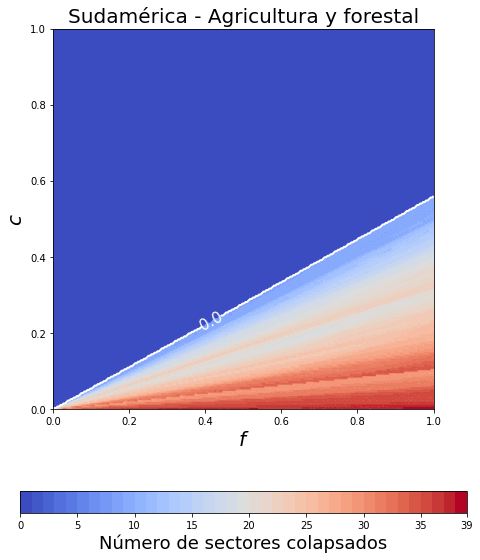

In [9]:
grafica_difusion_individual(matrices_agricultura['Sudamerica'], 'Sudamérica - Agricultura y forestal')

<AxesSubplot:title={'center':'Bolivia - Carne y derivados'}, xlabel='$f$', ylabel='$c$'>

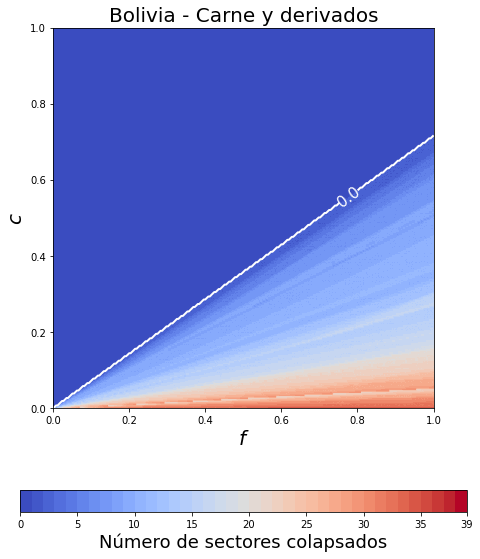

In [10]:
grafica_difusion_individual(matrices_carne['Bolivia'], 'Bolivia - Carne y derivados')

<AxesSubplot:title={'center':'Brasil - Finanzas y seguros'}, xlabel='$f$', ylabel='$c$'>

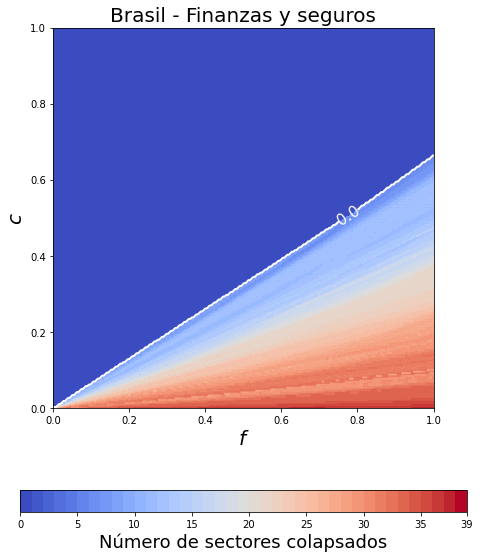

In [11]:
grafica_difusion_individual(matrices_otros_servicios['Brasil'], 'Brasil - Finanzas y seguros')

<AxesSubplot:title={'center':'Perú - Otros servicios'}, xlabel='$f$', ylabel='$c$'>

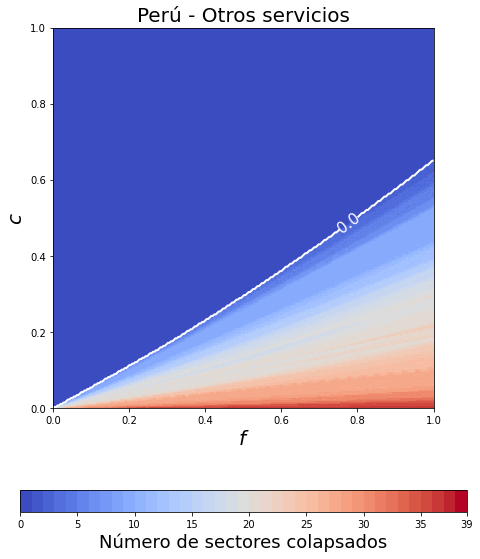

In [12]:
grafica_difusion_individual(matrices_otros_servicios['Peru'], 'Perú - Otros servicios')

### Se exportan las gráficas

In [32]:
try:
    os.mkdir('02 - Graficas sectores colapsados individuales')
except:
    print('La carpeta y las gráficas ya fueron creadas')
    
sectores_graficas = {'0':'Agricultura y forestal','4':'Carne y derivados', '37':'Finanzas y seguros', 
                     '39':'Otros servicios'}
  
for i,sector in sectores_graficas.items():
    try:
        os.mkdir('02 - Graficas sectores colapsados individuales/'+i+' - '+sector)
    except:
        print('La carpeta y las gráficas ya fueron creadas')

In [14]:
%%capture
#capture es para que esta celda no tenga output

for pais in paises_region:
    grafica_difusion_individual(
        matrices_agricultura[pais], pais+' - Agricultura y forestal', guardar=True).savefig \
    ('02 - Graficas sectores colapsados individuales/0 - Agricultura y forestal/'+pais+\
     '_Agricultura_y_forestal_SectoresColapsados.jpg', dpi =300)
    
    grafica_difusion_individual(matrices_carne[pais], pais+' - Carne y derivados', guardar=True).savefig \
    ('02 - Graficas sectores colapsados individuales/4 - Carne y derivados/'+pais+\
     '_Carne_y_derivados_SectoresColapsados.jpg', dpi =300)
    
    grafica_difusion_individual(matrices_finanzas[pais], pais+' - Finanzas y seguros', guardar=True).savefig \
    ('02 - Graficas sectores colapsados individuales/37 - Finanzas y seguros/'+pais+\
     '_Finanzas_y_seguros_SectoresColapsados.jpg', dpi =300)
    
    grafica_difusion_individual(matrices_otros_servicios[pais], pais+' - Otros servicios', guardar=True).savefig\
    ('02 - Graficas sectores colapsados individuales/39 - Otros servicios/'+pais+\
     '_Otros_servicios_SectoresColapsados.jpg', dpi =300)

----

###### Funcion graficas_difusion_pais

In [14]:
def graficas_difusion_pais(nombre_pais, guardar=False):
    
        '''
    Esta función grafica las curvas de nivel de las matrices obtenidas por la función
    numero_de_colapsos para un país y los cuatro sectores en conjunto
    

    Parámetros
    ----------
    nombre_pais : string
        El nombre del país o de la región de la cual se quiere obtener las gráficas
        
    guardar : bool, opcional, default=False
        Este parametro se usa para guardar y exportar la gráfica del modo que se desee
        
    '''
    
    
    matrices = [matrices_agricultura[nombre_pais], matrices_carne[nombre_pais], matrices_finanzas[nombre_pais],
            matrices_otros_servicios[nombre_pais]]

    titulos = [nombre_pais+' - Agricultura y forestal', nombre_pais+' - Carne y derivados', 
           nombre_pais+' - Finanzas y seguros', nombre_pais+' - Otros servicios']

    letras = ['a)','b)','c)','d)']
    

    fig, axs = plt.subplots(2,2, figsize=(20,20))

    cmap = mpl.cm.coolwarm
    bounds = list(range(41))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    for ax, matriz,titulo,inciso in zip(axs.flat, matrices, titulos, letras):
        im = ax.imshow(matriz, origin='lower', cmap= cmap, norm=norm ,extent=(0,1,0,1) )
        im.set_clim([0,39])

        #[1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
        countour = ax.contour(matriz,[0],linewidths=2,cmap=mpl.cm.binary, extent=(0,1,0,1))

        ax.clabel(countour, inline=True, fmt='%1.1f',fontsize=15)

        #cbar = fig.colorbar(im, use_gridspec=True, location='bottom', orientation='horizontal',ticks=tick_list,shrink=0.8) 
        #cbar.set_label('Número de sectores colapsados', size=18)
        ax.set_title( titulo, fontdict={'fontsize': 20})
        ax.set_xlabel("$f$\n\n{}".format(inciso), fontdict={'fontsize': 20})#, fontstyle ='italic')
        ax.set_ylabel('$c$', fontdict={'fontsize': 20})

    tick_list = list(range(1,40,2))

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.030, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax,ticks=tick_list)
    
    if guardar:
        return fig;

    return ax;

In [28]:
def graficas_difusion_pais(nombre_pais, guardar=False):
    
    
    '''
    Esta función grafica las curvas de nivel de las matrices obtenidas por la función
    numero_de_colapsos para un país y los cuatro sectores en conjunto
    
    
    Parámetros
    ----------
    nombre_pais : string
        El nombre del país o de la región de la cual se quiere obtener las gráficas
        
    guardar : bool, opcional, default=False
        Este parametro se usa para guardar y exportar la gráfica del modo que se desee
        
    '''
    
    matrices = [matrices_agricultura[nombre_pais], matrices_carne[nombre_pais], matrices_finanzas[nombre_pais],
            matrices_otros_servicios[nombre_pais]]
    
    titulos = [nombre_pais+' - Agricultura y forestal', nombre_pais+' - Carne y derivados', 
           nombre_pais+' - Finanzas y seguros', nombre_pais+' - Otros servicios']
    

    fig, axs = plt.subplots(2,2, figsize=(20,20))

    cmap = mpl.cm.coolwarm
    bounds = list(range(41))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    for ax, matriz,titulo in zip(axs.flat, matrices, titulos):
        im = ax.imshow(matriz, origin='lower', cmap= cmap, norm=norm ,extent=(0,1,0,1) )
        im.set_clim([0,39])

        #[1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
        countour = ax.contour(matriz,[0],linewidths=2,cmap=mpl.cm.binary, extent=(0,1,0,1))

        ax.clabel(countour, inline=True, fmt='%1.1f',fontsize=15)

        #cbar = fig.colorbar(im, use_gridspec=True, location='bottom', orientation='horizontal',ticks=tick_list,shrink=0.8) 
        #cbar.set_label('Número de sectores colapsados', size=18)
        ax.set_title( titulo, fontdict={'fontsize': 20})
        ax.set_xlabel("$f$", fontdict={'fontsize': 20})#, fontstyle ='italic')
        ax.set_ylabel('$c$', fontdict={'fontsize': 20})

    tick_list = list(range(1,40,2))

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.030, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax,ticks=tick_list)
    
    if guardar:
        return fig;

    return ax;

##### Ejemplos

<AxesSubplot:title={'center':'Sudamerica - Otros servicios'}, xlabel='$f$', ylabel='$c$'>

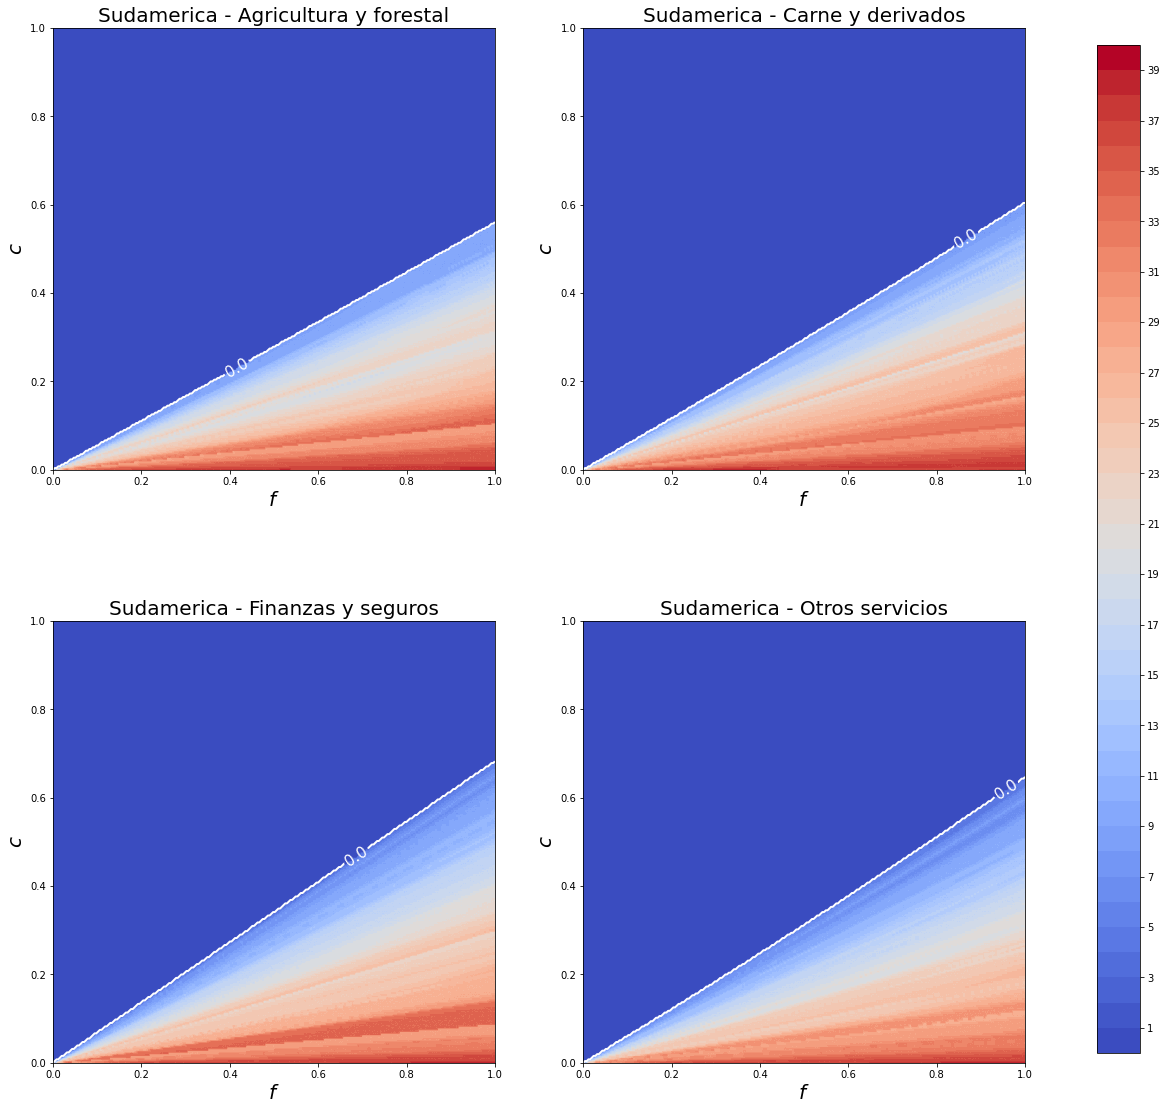

In [29]:
graficas_difusion_pais('Sudamerica')

<AxesSubplot:title={'center':'Paraguay - Otros servicios'}, xlabel='$f$', ylabel='$c$'>

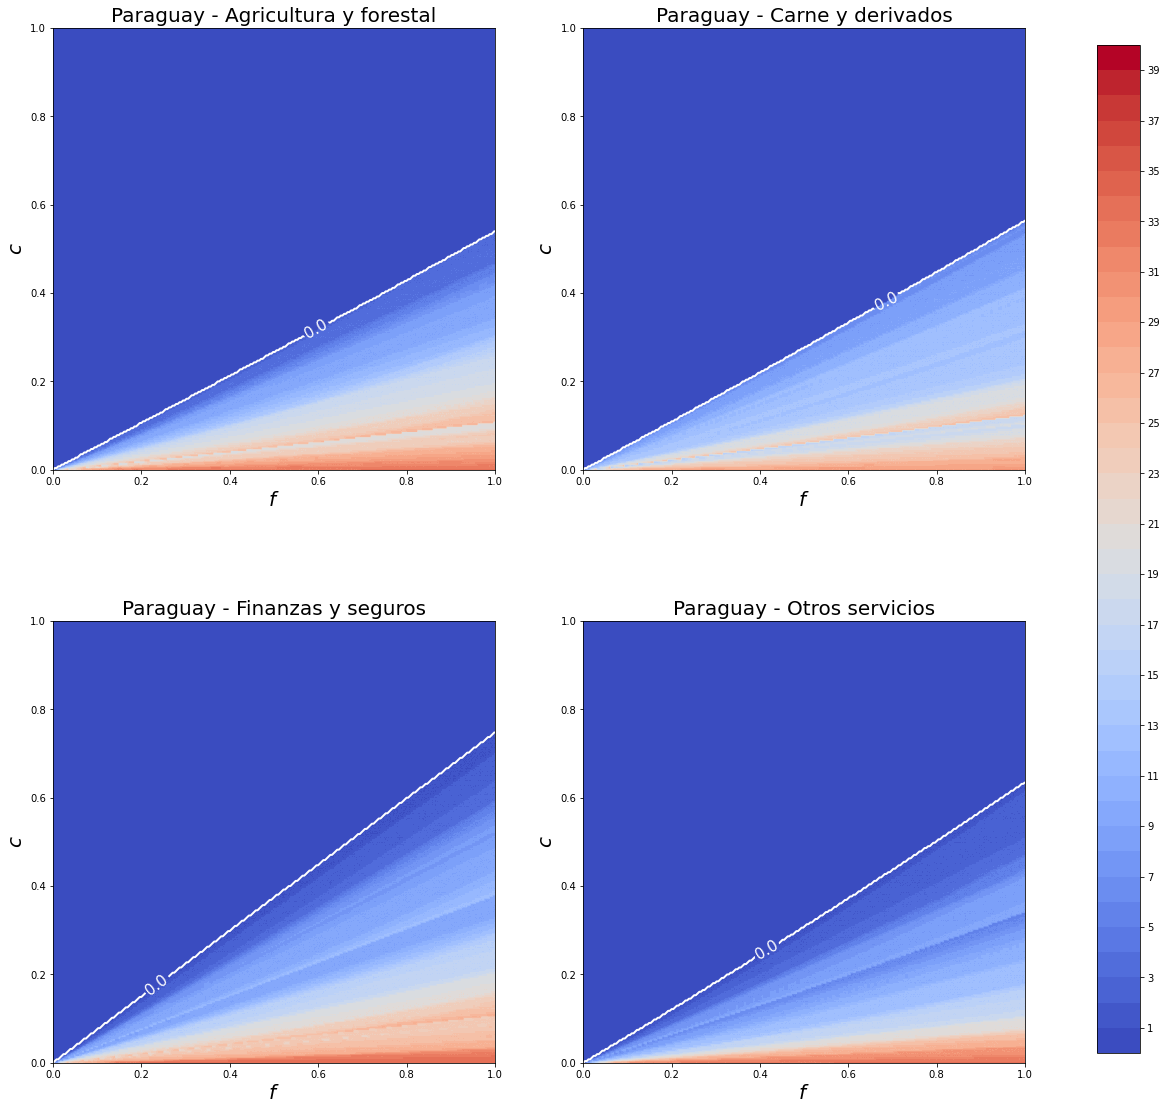

In [30]:
graficas_difusion_pais('Paraguay')

<AxesSubplot:title={'center':'Argentina - Otros servicios'}, xlabel='$f$', ylabel='$c$'>

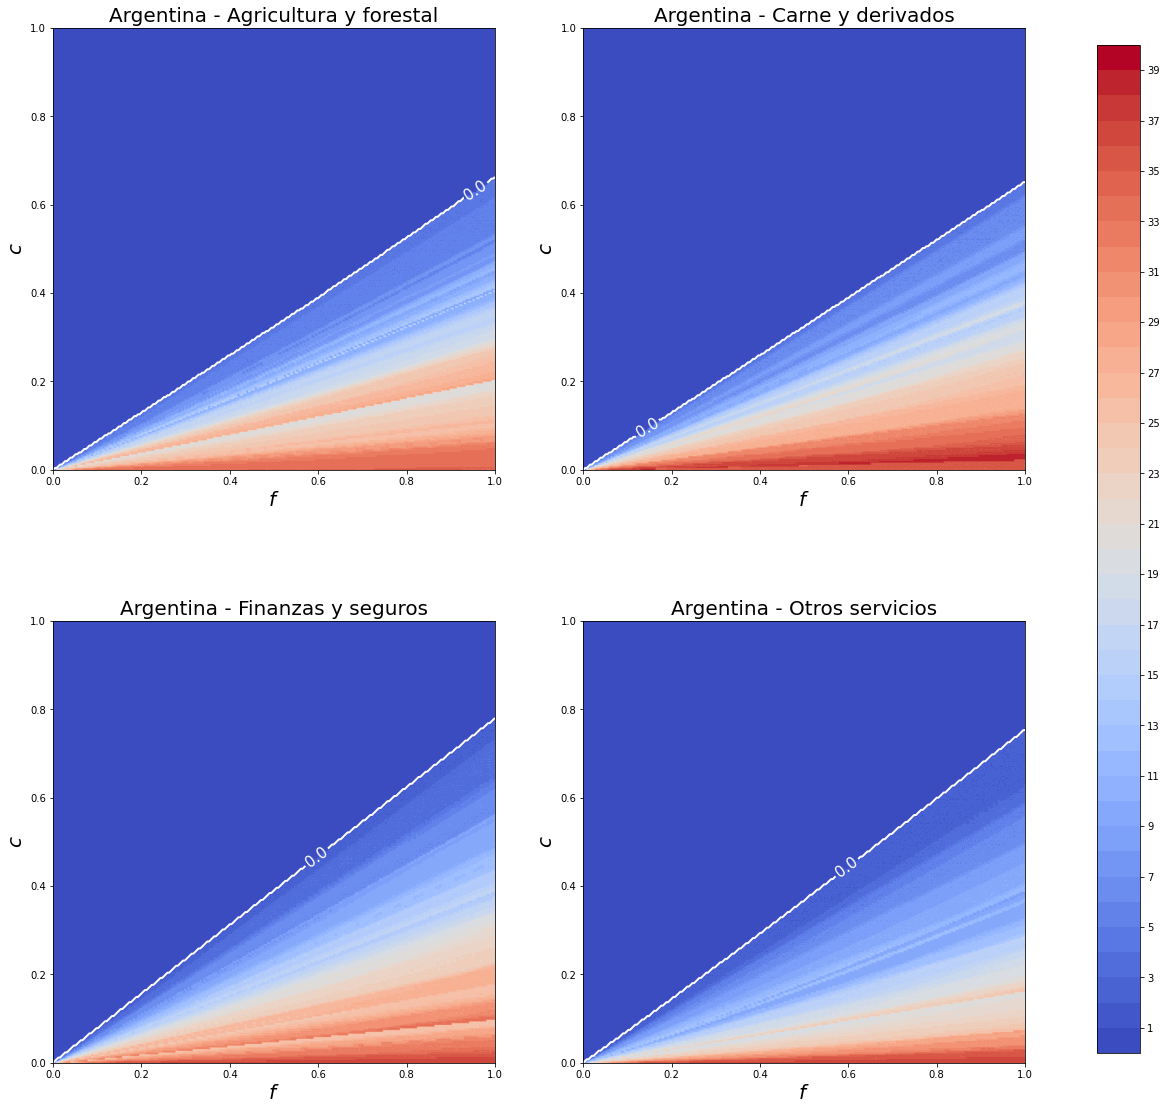

In [31]:
graficas_difusion_pais('Argentina')

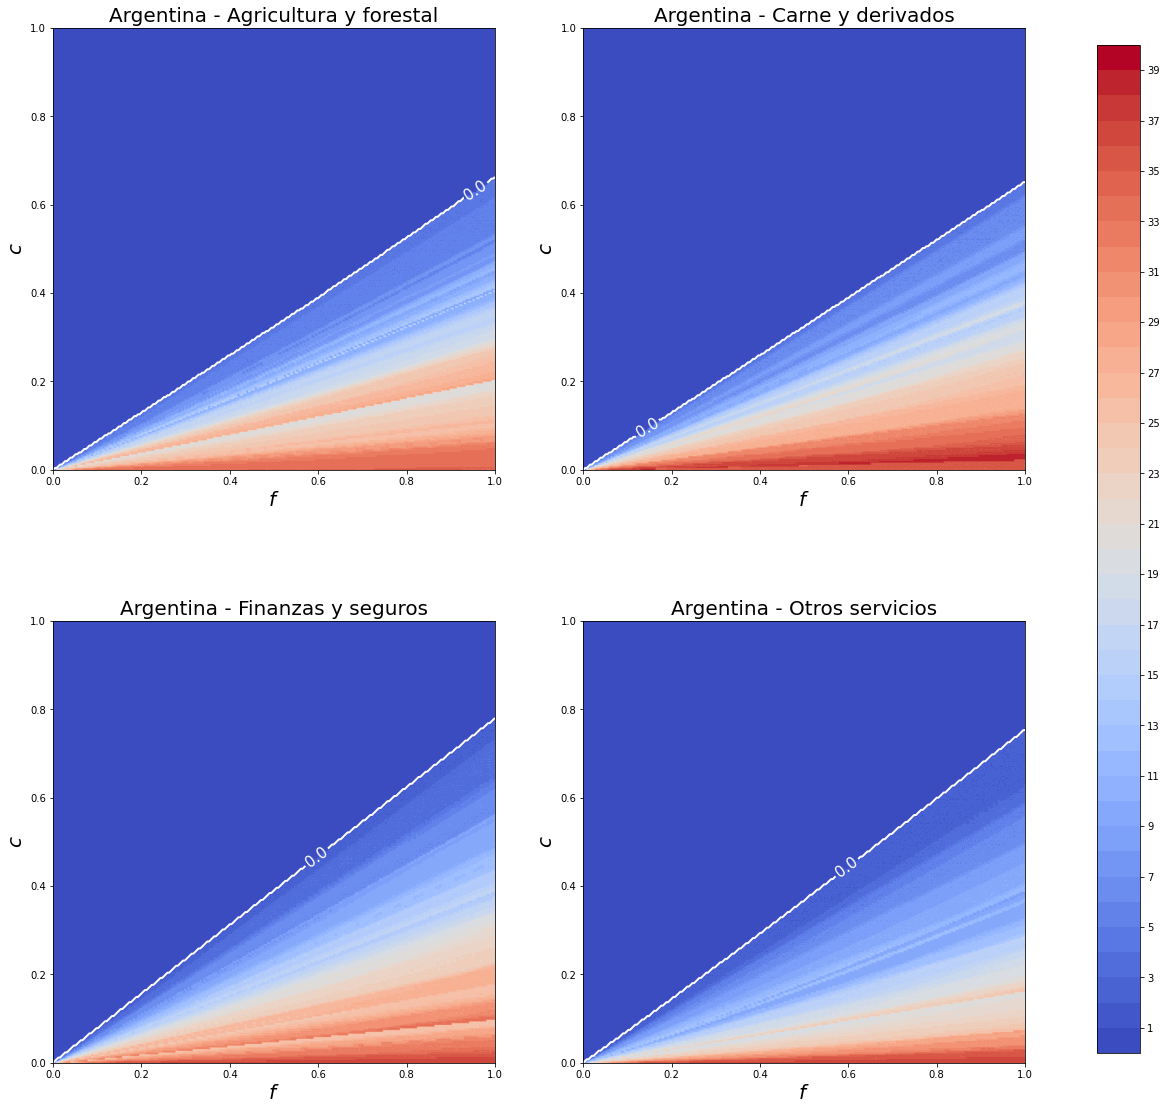

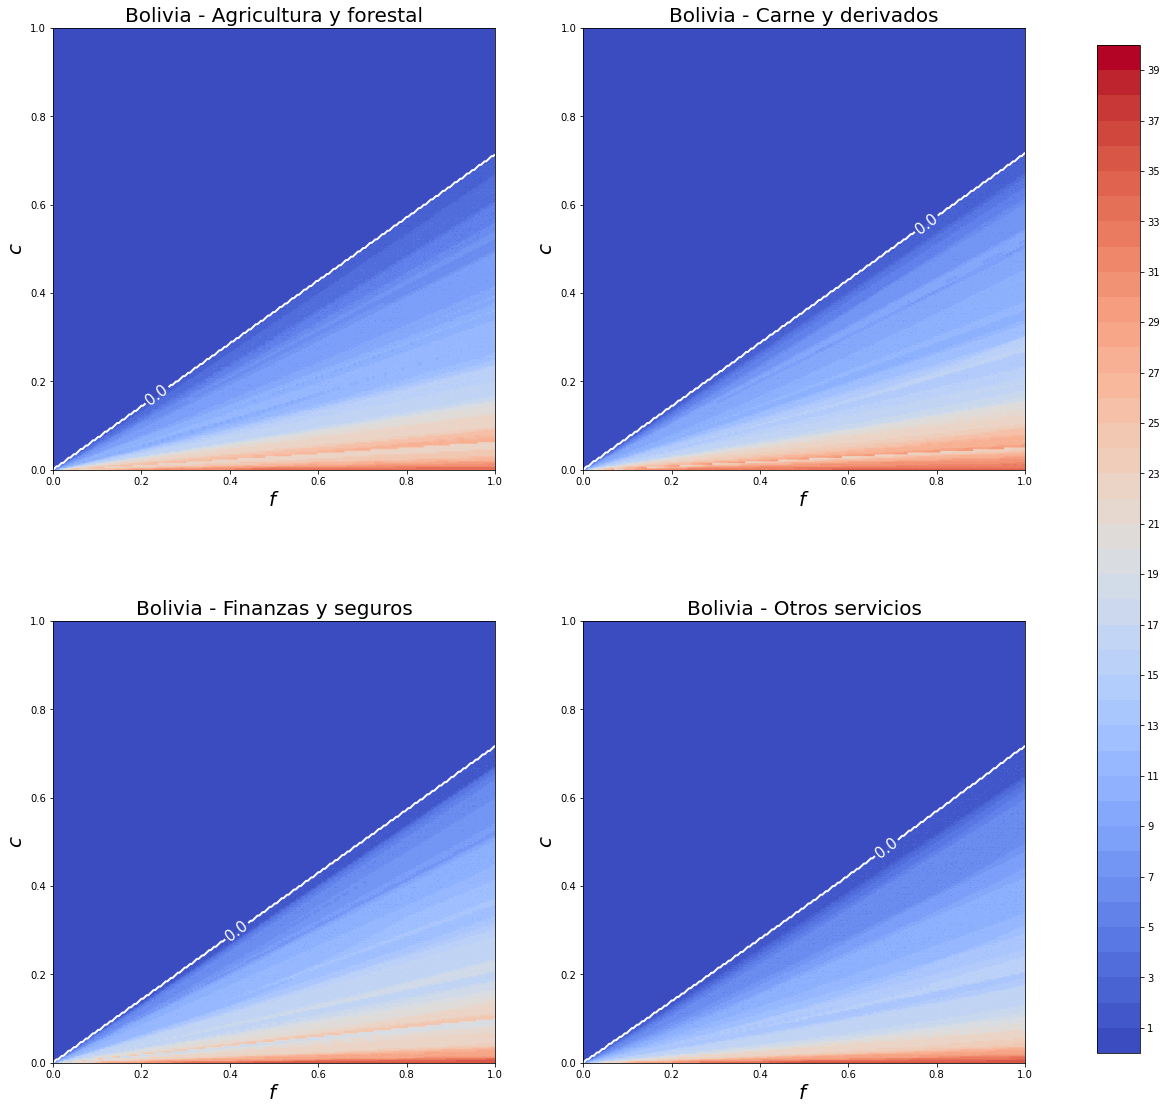

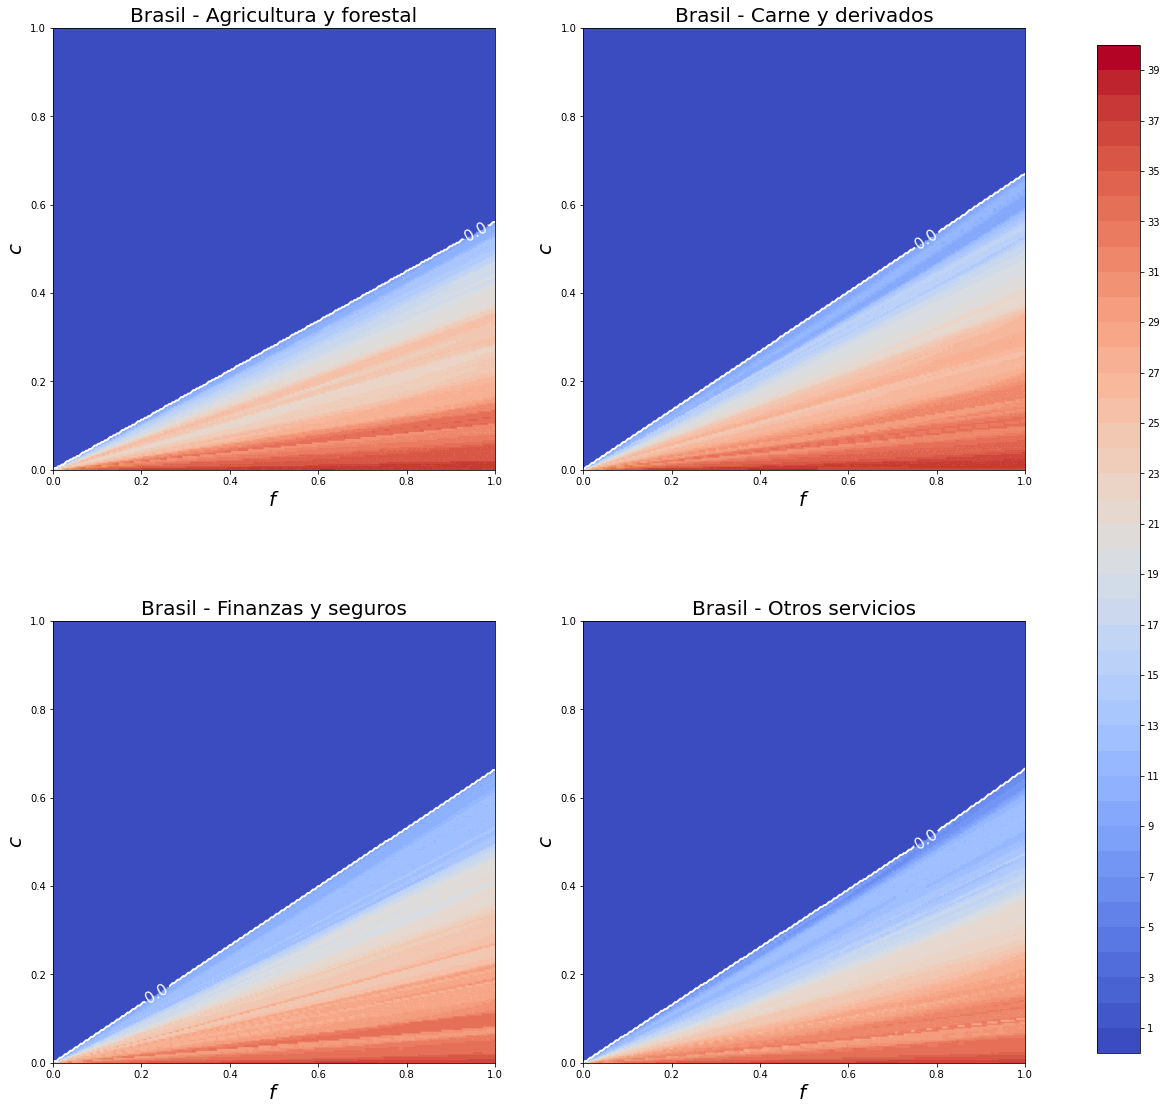

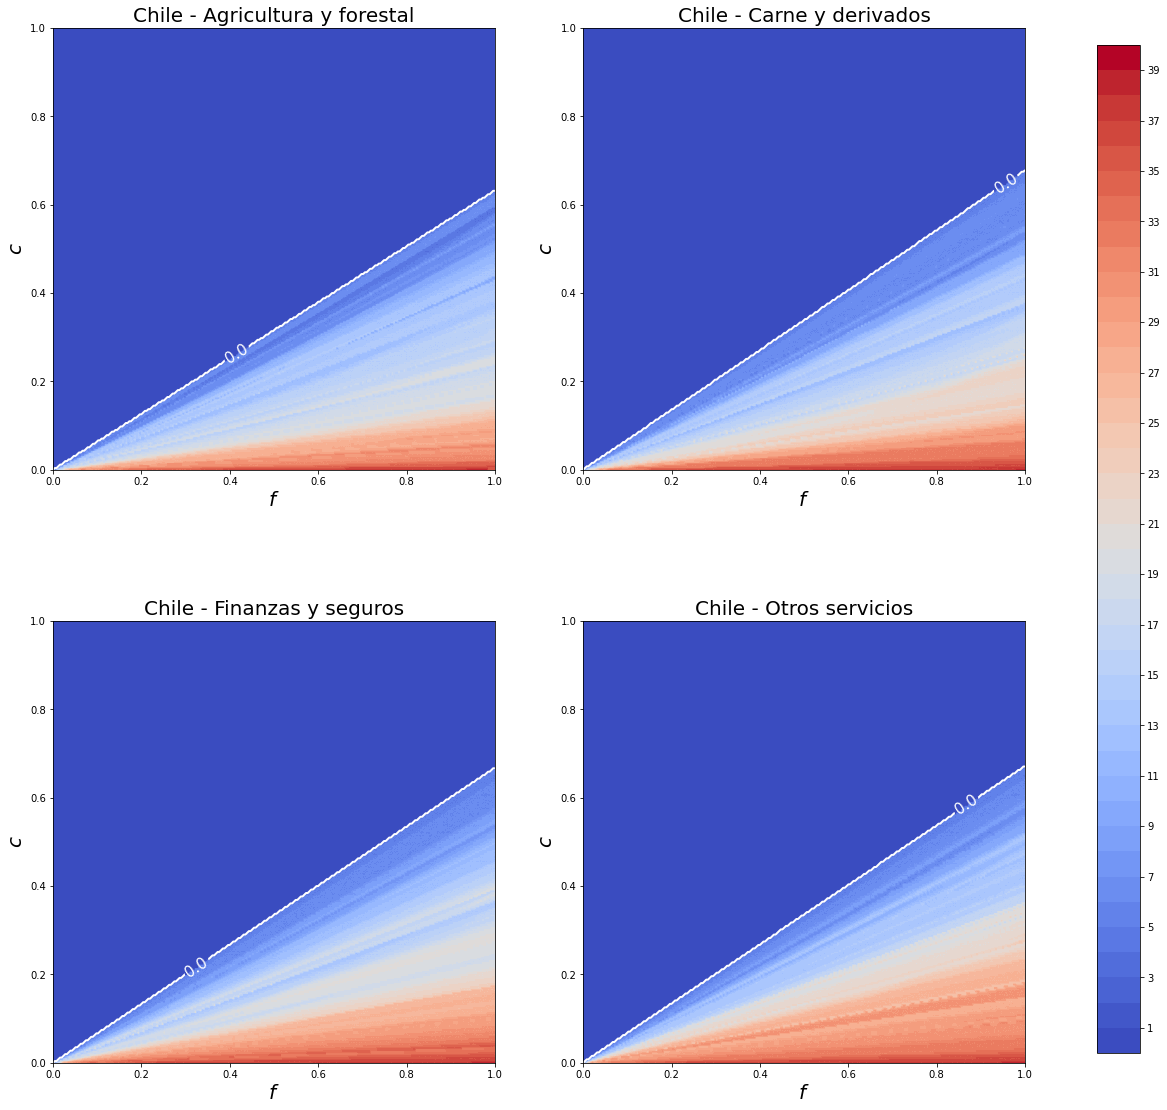

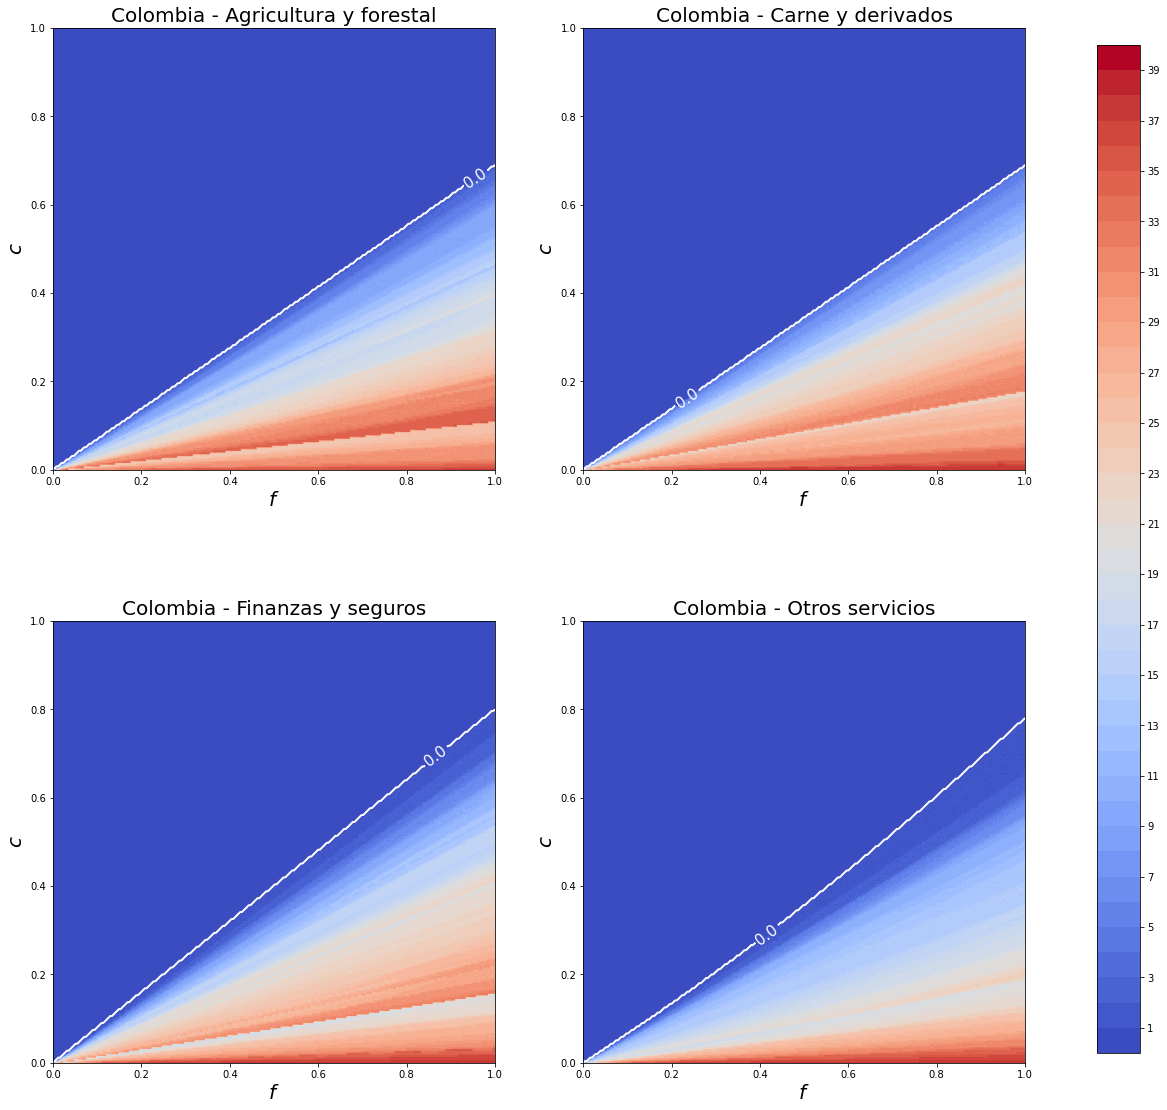

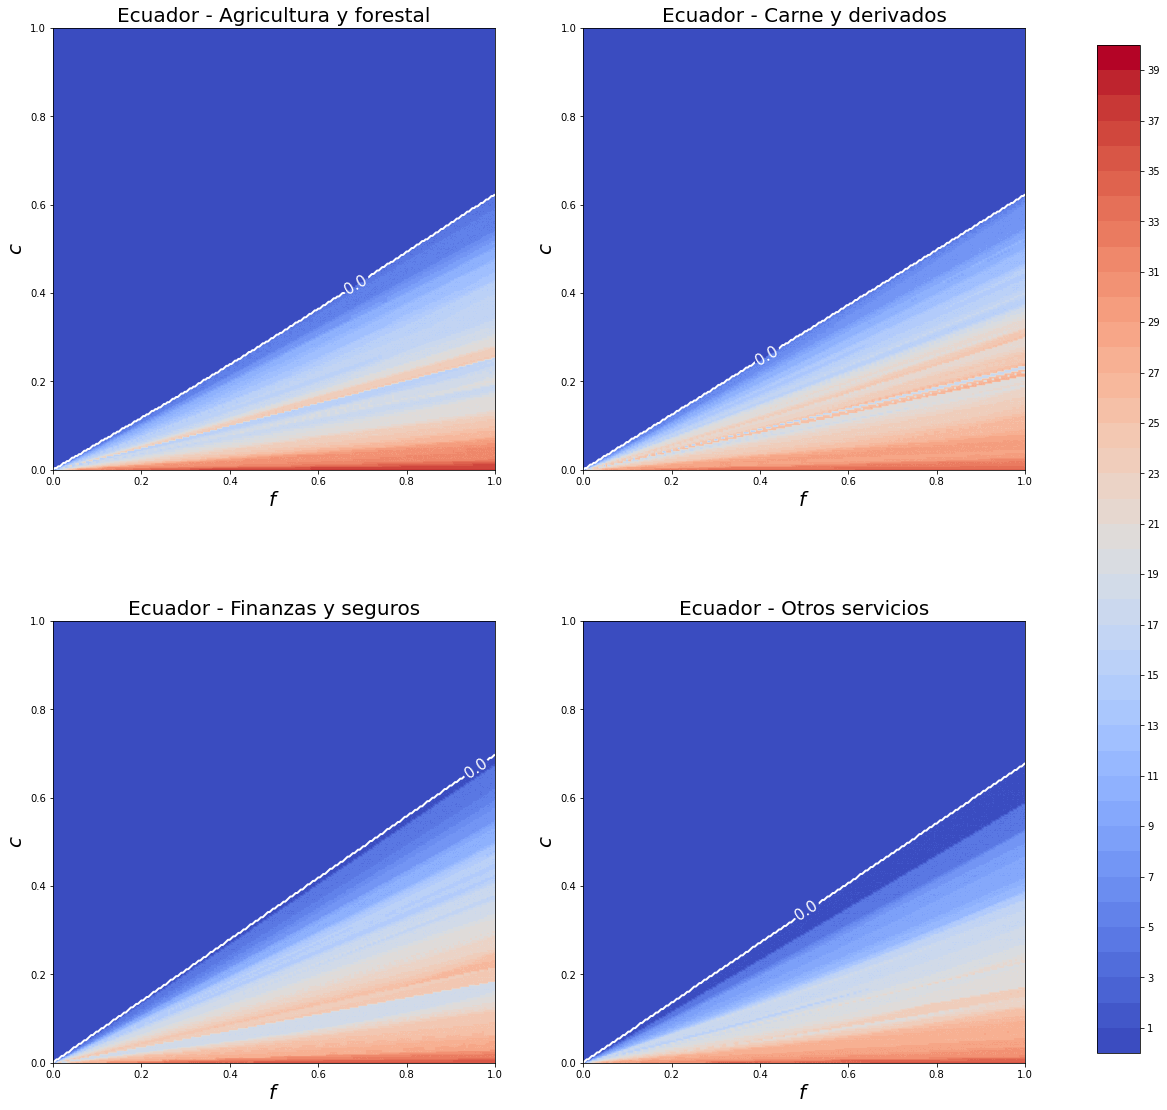

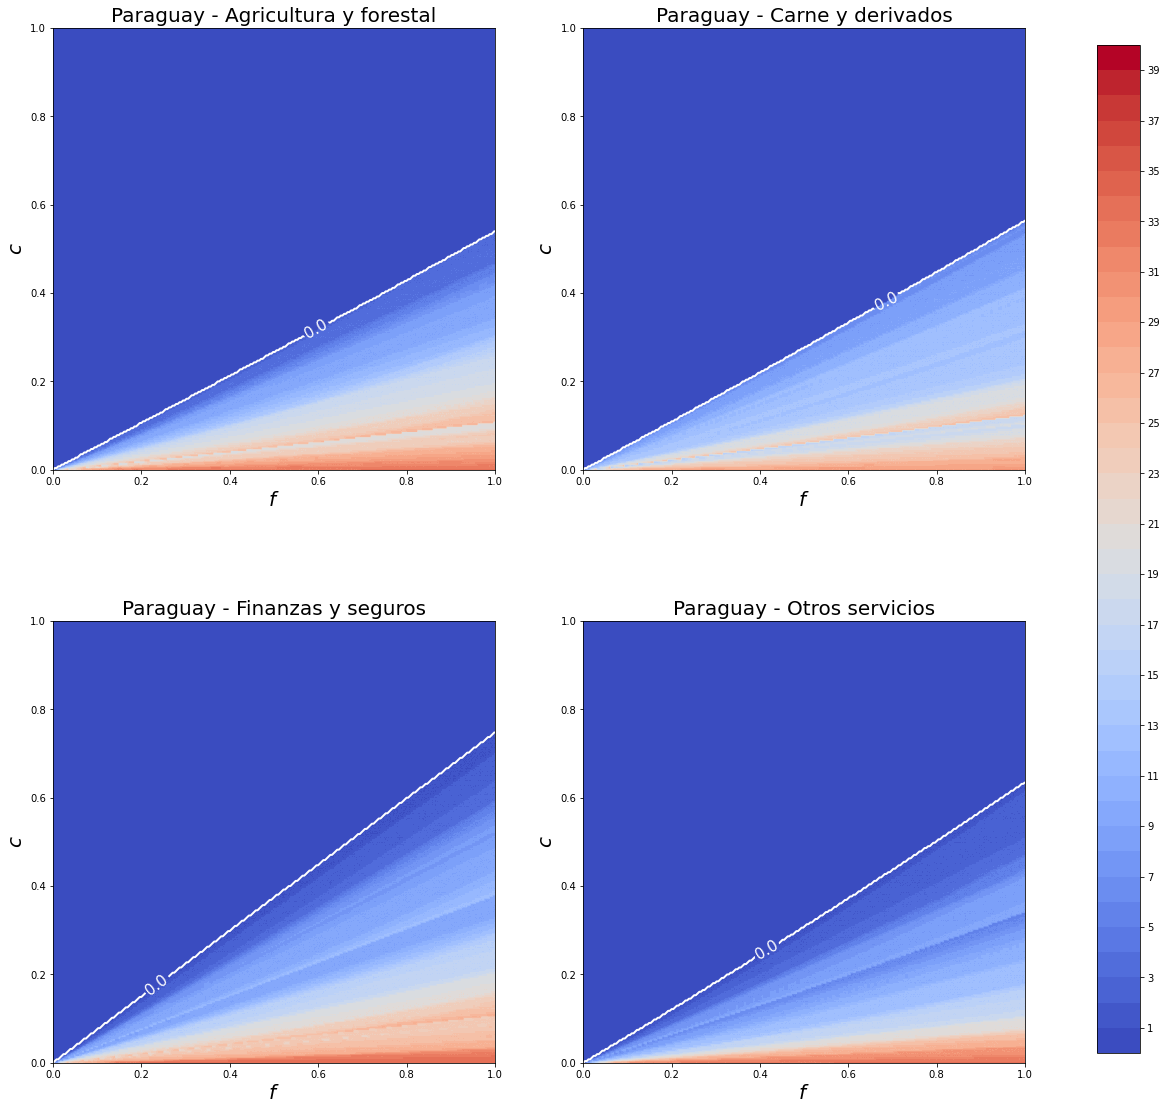

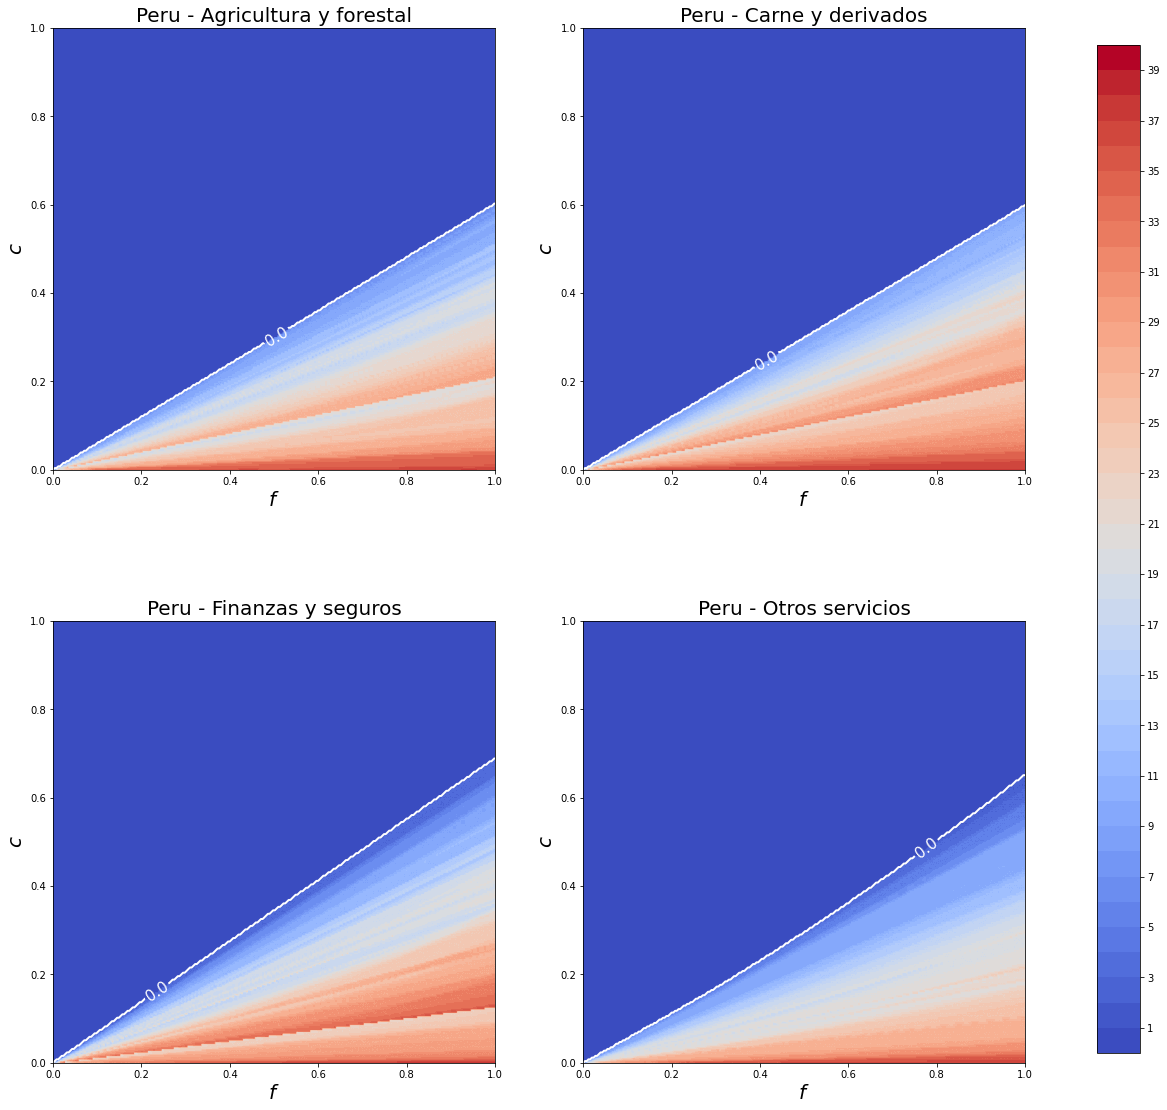

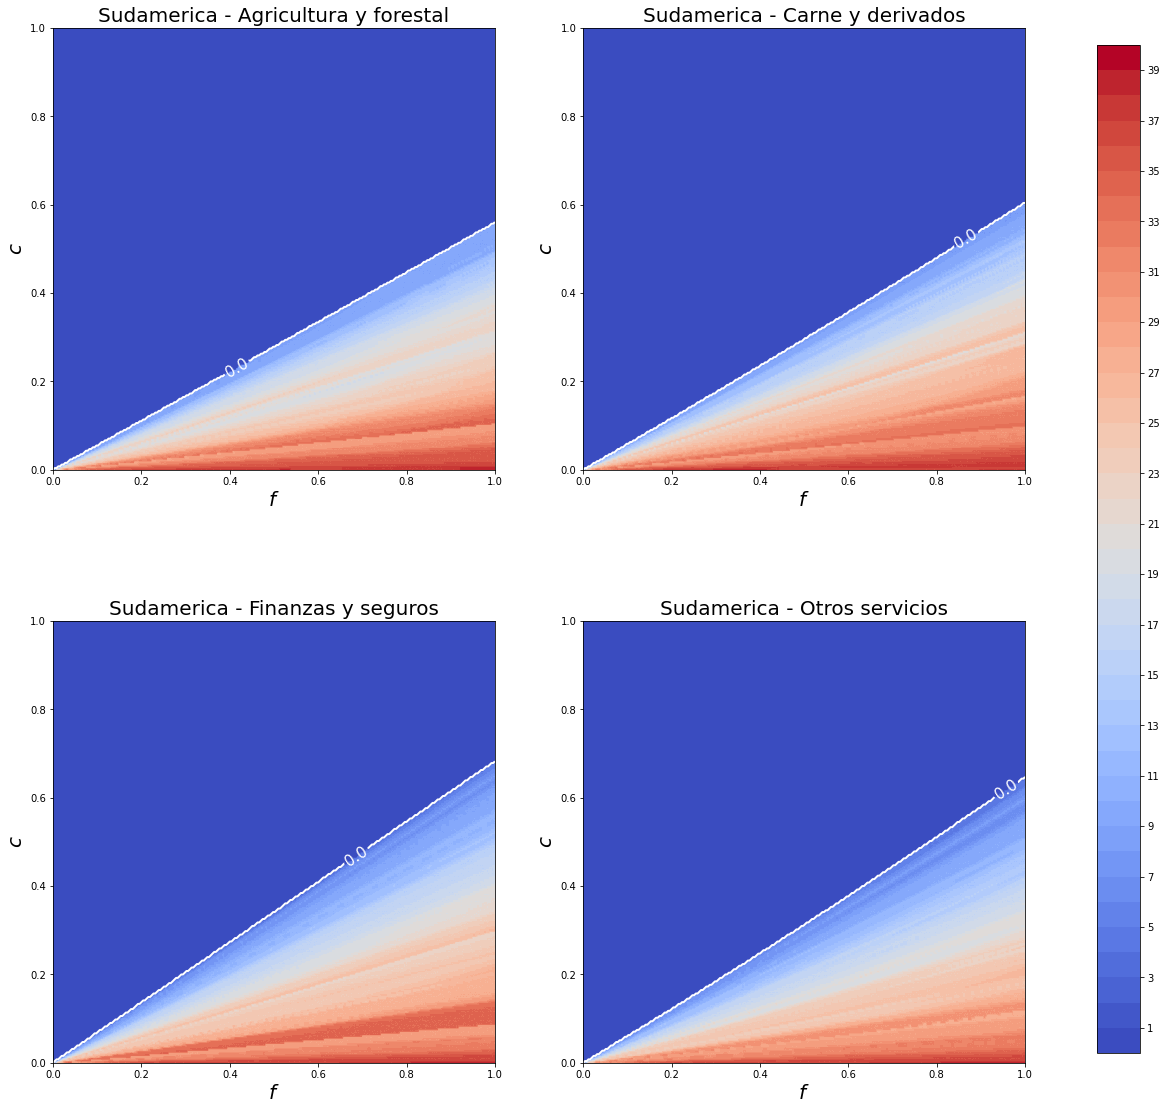

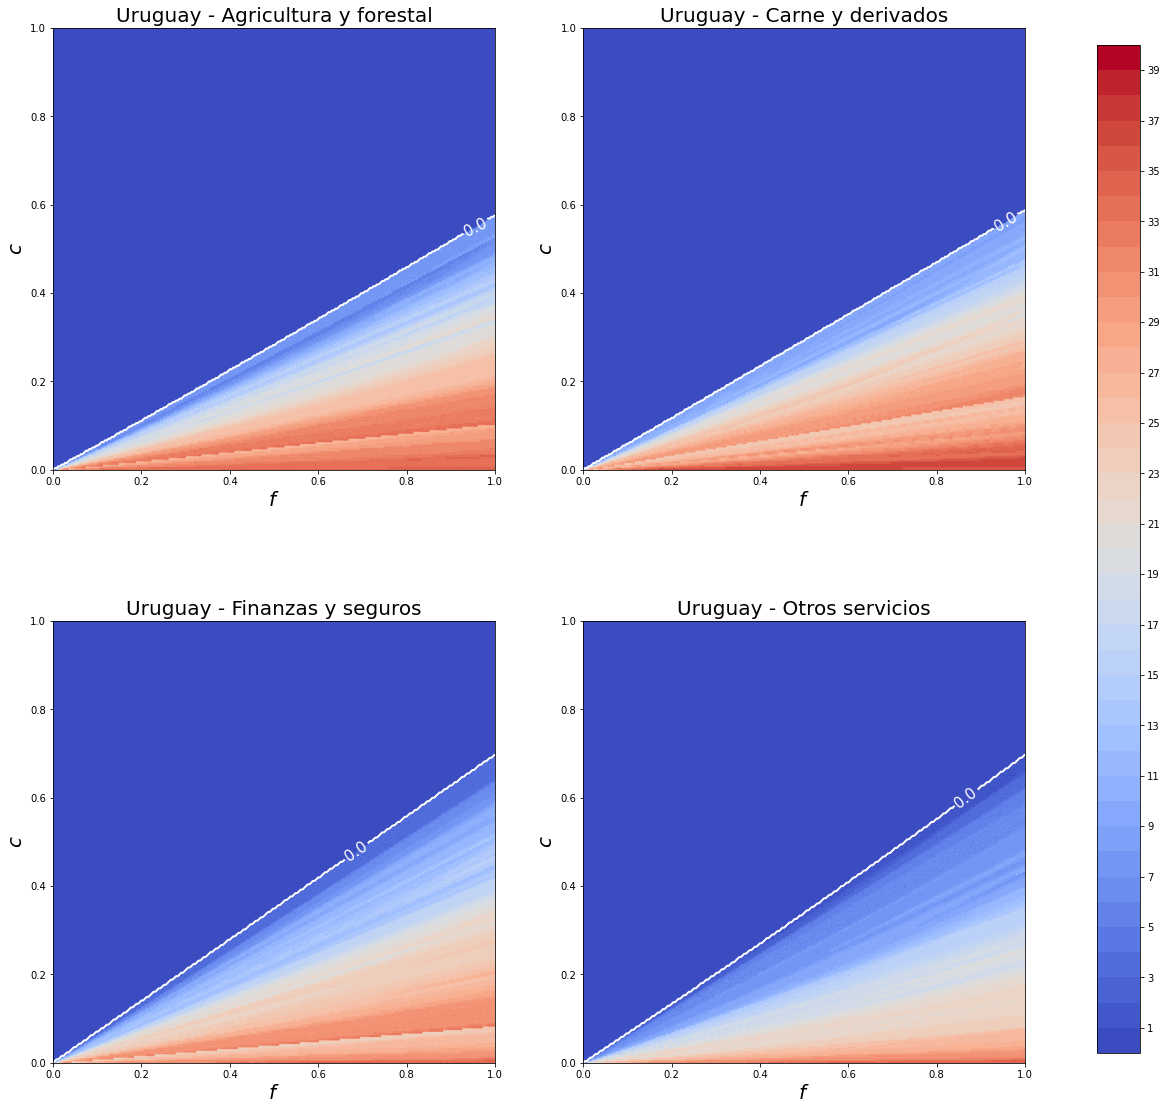

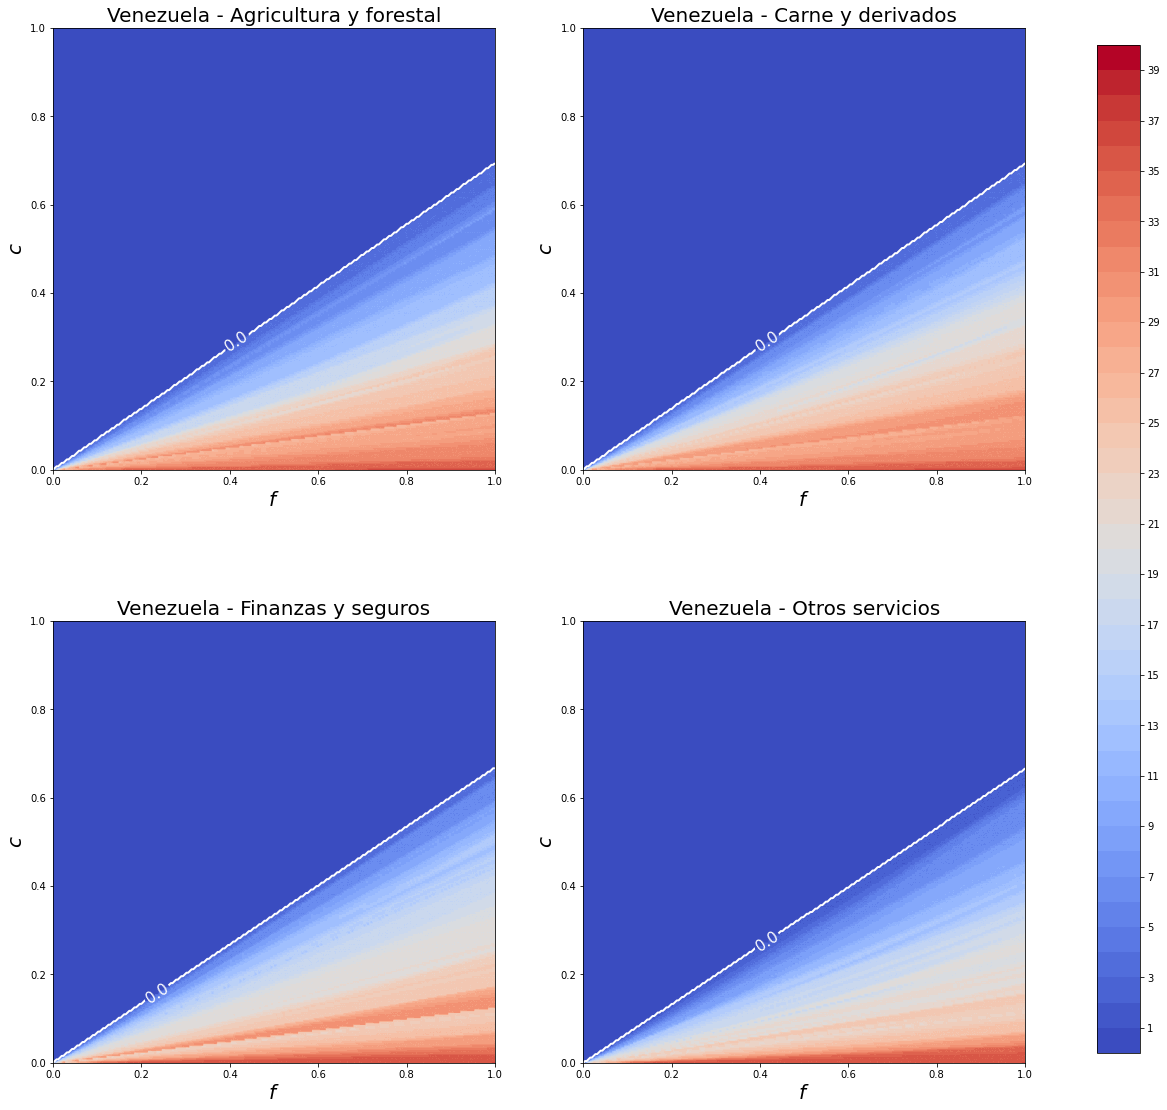

In [32]:
for i in paises_region:
    graficas_difusion_pais(i)

### Se exportan las gráficas

In [18]:
try:
    os.mkdir('03 - Graficas sectores colapsados en conjunto')
except:
    print('La carpeta y las gráficas ya fueron creadas')

In [20]:
%%capture
for pais in paises_region:
    graficas_difusion_pais(pais, guardar=True).savefig(
    '03 - Graficas sectores colapsados en conjunto/'+pais+'_SectoresColapsadosConjunto.jpg', dpi = 300)

----

## Áreas de sección con sectores colapsados

En esta sección se obtuvo el área de la gráficas donde hubo un impacto mayores o iguales a 1 y para ello, se contaron las celdas distintas de ceros y se dividió entre el número total de celdas

In [17]:
# n representa el número de filas y columnas de las matrices
n = len(matrices_agricultura['Argentina'])

areas_total_agricultura     = dict((pais, np.count_nonzero(matrices_agricultura[pais])/n**2) 
                               for pais in paises_region)

areas_total_carne           = dict((pais, np.count_nonzero(matrices_carne[pais])/n**2) 
                               for pais in paises_region)

areas_total_finanzas        = dict((pais, np.count_nonzero(matrices_finanzas[pais])/n**2) 
                               for pais in paises_region)

areas_total_otros_servicios = dict((pais, np.count_nonzero(matrices_otros_servicios[pais])/n**2) 
                                for pais in paises_region)

In [18]:
areas_df = pd.DataFrame({'Agricultura y forestal': pd.Series(areas_total_agricultura),
                         'Carne y derivados': pd.Series(areas_total_carne),
                         'Finanzas y seguros' : pd.Series(areas_total_finanzas),
                         'Otros servicios' : pd.Series(areas_total_otros_servicios)}, index=paises_region)

areas_df

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
Argentina,0.325928,0.323853,0.388718,0.369827
Bolivia,0.355682,0.357407,0.356766,0.353012
Brasil,0.279755,0.334229,0.330750,0.326752
Chile,0.314896,0.337738,0.332886,0.334671
Colombia,0.344009,0.343475,0.399216,0.367096
Ecuador,0.303497,0.310013,0.347473,0.337891
Paraguay,0.266418,0.277237,0.372681,0.310089
Peru,0.299332,0.297974,0.343536,0.305267
Sudamerica,0.277863,0.296783,0.340210,0.315125
Uruguay,0.283752,0.292435,0.347610,0.341095


In [19]:
areas_df.describe(include='all')

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
count,11.000000,11.000000,11.000000,11.000000
mean,0.308803,0.319690,0.353925,0.335581
std,0.030777,0.026155,0.023245,0.021440
min,0.266418,0.277237,0.330750,0.305267
25%,0.281754,0.297379,0.336769,0.320938
50%,0.303497,0.323853,0.347473,0.334671
75%,0.334969,0.340607,0.364723,0.347054
max,0.355682,0.357407,0.399216,0.369827


---

## Área de impactos mayor estricto a 20

Semejante a lo que se hizo la sección anterior, solo que esta vez, fue para impactos mayor estricto a 20

In [20]:
areas_mayores_agricultura     = dict((pais, np.count_nonzero(matrices_agricultura[pais]>20)/n**2) 
                                 for pais in paises_region)

areas_mayores_carne           = dict((pais, np.count_nonzero(matrices_carne[pais]>20)/n**2) 
                                 for pais in paises_region)

areas_mayores_finanzas        = dict((pais, np.count_nonzero(matrices_finanzas[pais]>20)/n**2) 
                                 for pais in paises_region)

areas_mayores_otros_servicios = dict((pais, np.count_nonzero(matrices_otros_servicios[pais]>20)/n**2) 
                                 for pais in paises_region)

In [21]:
areas_mayores_df = pd.DataFrame({'Agricultura y forestal': pd.Series(areas_mayores_agricultura),
                         'Carne y derivados': pd.Series(areas_mayores_carne),
                         'Finanzas y seguros' : pd.Series(areas_mayores_finanzas),
                         'Otros servicios' : pd.Series(areas_mayores_otros_servicios)}, index=paises_region)

areas_mayores_df

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
Argentina,0.133484,0.137100,0.147614,0.079620
Bolivia,0.070770,0.067917,0.057632,0.039459
Brasil,0.195038,0.201859,0.195358,0.176758
Chile,0.075623,0.110870,0.106369,0.159607
Colombia,0.158371,0.210739,0.198303,0.085175
Ecuador,0.082794,0.150513,0.122208,0.086395
Paraguay,0.077972,0.049774,0.083313,0.042603
Peru,0.151001,0.189774,0.161392,0.095947
Sudamerica,0.164886,0.192200,0.182281,0.149139
Uruguay,0.152237,0.189713,0.168793,0.092850


In [22]:
areas_mayores_df.describe(include='all')

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
count,11.000000,11.000000,11.000000,11.000000
mean,0.127740,0.151162,0.141407,0.100831
std,0.043257,0.054714,0.045913,0.044387
min,0.070770,0.049774,0.057632,0.039459
25%,0.080383,0.123985,0.114288,0.082397
50%,0.142960,0.162323,0.147614,0.092850
75%,0.155304,0.190987,0.175537,0.125366
max,0.195038,0.210739,0.198303,0.176758


---

## Máximas avalanchas

Aquí lo se hizo fue obtener el número máximo de impactos de todas las matrices para todos los grafos

In [23]:
maximos_agricultura     = dict ( (pais, matrices_agricultura[pais].max()) for pais in paises_region)
maximos_carne           = dict ( (pais, matrices_carne[pais].max()) for pais in paises_region)
maximos_finanzas        = dict ( (pais, matrices_finanzas[pais].max()) for pais in paises_region)
maximos_otros_servicios = dict ( (pais, matrices_otros_servicios[pais].max()) for pais in paises_region)

In [24]:
maximos_df = pd.DataFrame({'Agricultura y forestal': pd.Series(maximos_agricultura),
                         'Carne y derivados': pd.Series(maximos_carne),
                         'Finanzas y seguros' : pd.Series(maximos_finanzas),
                         'Otros servicios' : pd.Series(maximos_otros_servicios)}, index=paises_region)

maximos_df

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
Argentina,35.0,38.0,36.0,36.0
Bolivia,33.0,34.0,35.0,35.0
Brasil,38.0,38.0,37.0,37.0
Chile,38.0,38.0,38.0,38.0
Colombia,37.0,37.0,37.0,37.0
Ecuador,37.0,34.0,35.0,35.0
Paraguay,33.0,30.0,33.0,33.0
Peru,37.0,37.0,37.0,36.0
Sudamerica,38.0,38.0,38.0,38.0
Uruguay,34.0,36.0,35.0,34.0


In [25]:
maximos_df.describe(include='all')

,Agricultura y forestal,Carne y derivados,Finanzas y seguros,Otros servicios
count,11.000000,11.00000,11.000000,11.000000
mean,36.000000,36.00000,36.090909,35.909091
std,1.949359,2.48998,1.513575,1.578261
min,33.000000,30.00000,33.000000,33.000000
25%,34.500000,35.00000,35.000000,35.000000
50%,37.000000,37.00000,36.000000,36.000000
75%,37.500000,38.00000,37.000000,37.000000
max,38.000000,38.00000,38.000000,38.000000


---

### Exportando los tres dataframes obtenidos

In [45]:
try:
    os.mkdir('04 - Analisis del modelo de difusion')
    
    areas_df.to_csv(r'04 - Analisis del modelo de difusion/Areas totales de colapsos.csv')
    areas_mayores_df.to_csv(r'04 - Analisis del modelo de difusion/Areas de colapsos mayores a 20.csv')
    maximos_df.to_csv(r'04 - Analisis del modelo de difusion/Maximos de avalanchas.csv')
    
except:
    print('La carpeta y las tablas ya fueron creadas')

----

# Correlaciones entre el modelo de difusión y propiedades estructurales

## Correlaciones densidad ponderada con áreas de impactos mayores a 20

Una correlación significativa fue la que se halló entre la densidad ponderada y las áreas con impactos mayores a 20 en los cuatro sectores

In [ ]:
#Introduzca dirección local
densidades_ponderadas_df = pd.read_csv(
    r'Introduzca aquí dirección local/.../04 - Analisis de redes/Densidades normal y ponderada.csv',\
                            skiprows=[0], usecols=[2,3])

densidades_ponderadas_df.columns = ['Grafo', 'Densidad Ponderada']
#densidades_ponderadas_df.sort_values('Grafo',inplace=True)
#densidades_ponderadas_df.reset_index(inplace=True)

densidades_ponderadas_list = densidades_ponderadas_df['Densidad Ponderada'].to_list()

densidades_ponderadas_df

Es el resultado de la siguiente celda se puede apreciar los valores de correlación

In [27]:
index = ['Agricultura y forestal','Carne y derivados','Finanzas y seguros','Otros servicios']
Y = [list(areas_mayores_agricultura.values()), list(areas_mayores_carne.values()),
list(areas_mayores_finanzas.values()), list(areas_mayores_otros_servicios.values())]

r_s = []
valor_p = []

for sector, vector in zip(index,Y):
    correlacion = spearmanr(vector, densidades_ponderadas_list)
    
    r_s.append(correlacion[0])
    valor_p.append(correlacion[1])
    
corr_densidades_areas_may = pd.DataFrame({
    '$r_s$': r_s,
    'Valor $p$' : valor_p}, index=index)

corr_densidades_areas_may

,$r_s$,Valor $p$
Agricultura y forestal,0.572727,0.065543
Carne y derivados,0.563636,0.070952
Finanzas y seguros,0.609091,0.046696
Otros servicios,0.718182,0.012800


### Diagrama dispersión de las correlaciones

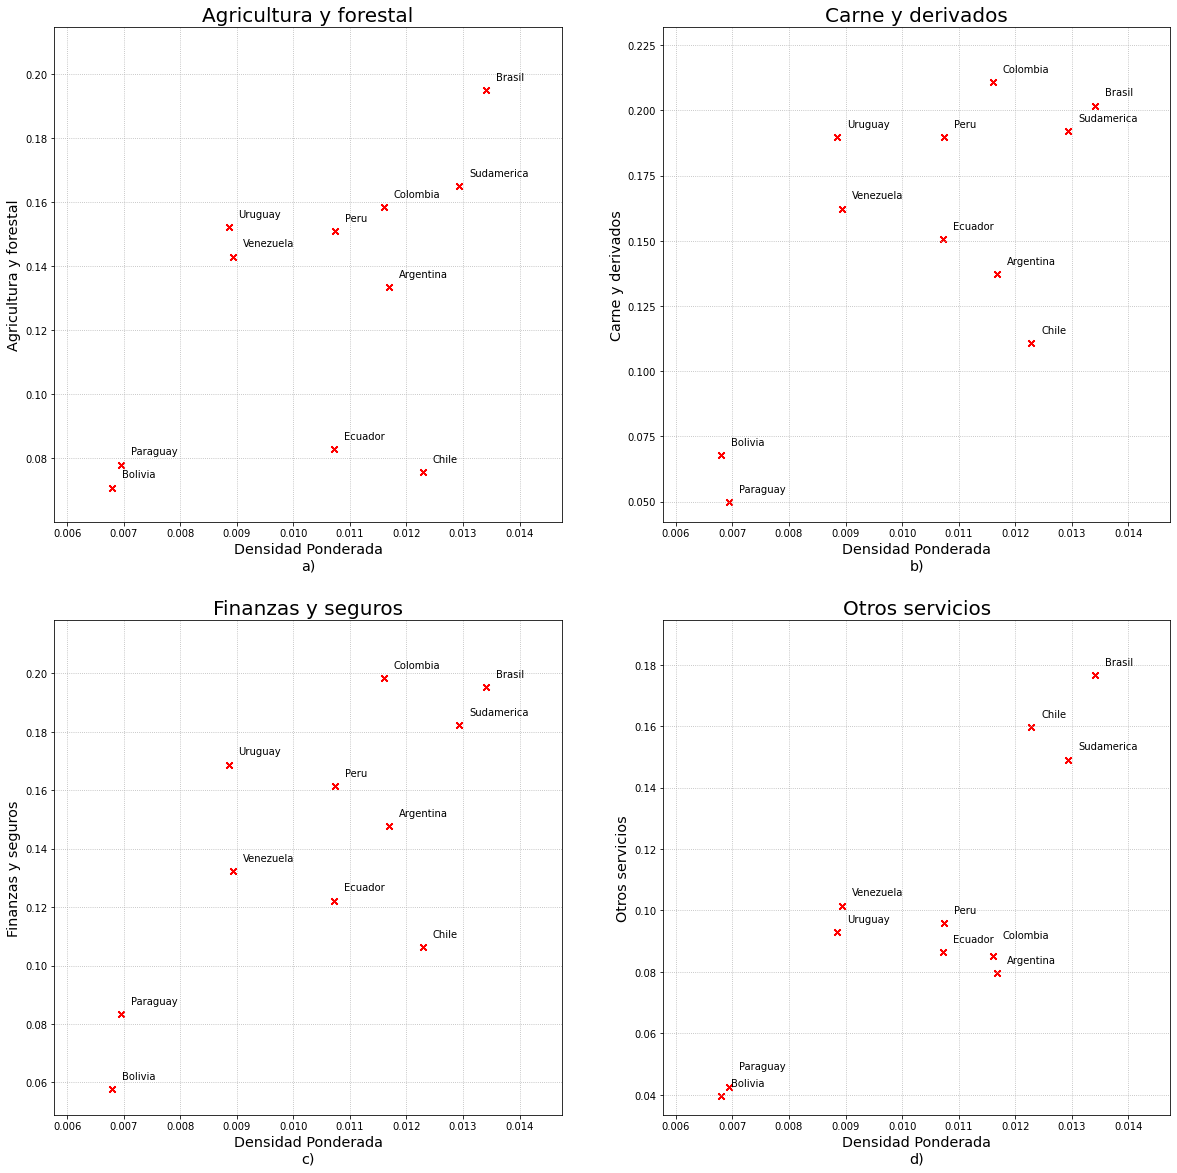

In [28]:
x = densidades_ponderadas_list
Y = [list(areas_mayores_agricultura.values()), list(areas_mayores_carne.values()),
list(areas_mayores_finanzas.values()), list(areas_mayores_otros_servicios.values())]

titulos = ['Agricultura y forestal', 'Carne y derivados',
           'Finanzas y seguros', 'Otros servicios']

letras = ['a)', 'b)', 'c)', 'd)']

fig, axs = plt.subplots(2,2, figsize=(20,20))

for ax, y, titulo, letra in zip(axs.flat, Y, titulos, letras): 

    ax.set_title(titulo, fontdict={'fontsize': 20})
    ax.set_xlabel('Densidad Ponderada\n{}'.format(letra), fontsize='x-large')
    ax.set_ylabel(str(titulo), fontsize='x-large')
    ax.grid(linestyle=':')
    ax.set_xlim(min(x)*(1-.15), max(x)*(1+.10))
    ax.set_ylim(min(y)*(1-.15), max(y)*(1+.10))

    if titulo == 'Otros servicios':
        
        y_1 = y.copy()
        y_1[6]= y_1[6] + 0.0025
        y_1[4]= y_1[4] + 0.0025
        
        for i, txt in enumerate(list(areas_mayores_finanzas.keys())):
            ax.annotate(txt, (x[i], y_1[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')
            
    else:
        for i, txt in enumerate(list(areas_mayores_finanzas.keys())):
            ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')

----

## Centralidad de caminante aleatorio y máximos totales

También se encontró correlación entre los máximos y la centralidad de caminante aleatorio de en cada sector considerado

In [ ]:
#Introduzca aquí dirección local
dir_medidas_centralidad=sorted(glob.glob(\
    r'Introduzca aquí dirección local/.../04 - Analisis de redes/01 - Tablas medidas de centralidad/*.csv'))


medidas_centralidad = dict( (pais, pd.read_csv(df, index_col='Sector')) 
                           for pais, df in zip(paises_region, dir_medidas_centralidad))

In [30]:
rwc_agricultura     = dict((pais,medidas_centralidad[pais].iloc[0]['Random Walk Centrality'] ) 
                       for pais in paises_region)

rwc_carne           = dict((pais,medidas_centralidad[pais].iloc[4]['Random Walk Centrality'] ) 
                       for pais in paises_region)

rwc_finanzas        = dict((pais,medidas_centralidad[pais].iloc[37]['Random Walk Centrality'] ) 
                       for pais in paises_region)

rwc_otros_servicios = dict((pais,medidas_centralidad[pais].iloc[39]['Random Walk Centrality'] ) 
                       for pais in paises_region)

En el resultado de la siguiente celda se muestran los valores de las correlaciones obtenidas

In [31]:
index = ['Agricultura y forestal','Carne y derivados','Finanzas y seguros','Otros servicios']

X = [list(rwc_agricultura.values()), list(rwc_carne.values()),
list(rwc_finanzas.values()), list(rwc_otros_servicios.values())]

Y = [list(maximos_agricultura.values()), list(maximos_carne.values()), 
     list(maximos_finanzas.values()), list(maximos_otros_servicios.values())]

r_s = []
valor_p = []

for x, y in zip(X,Y):
    correlacion = spearmanr(x, y)
    
    r_s.append(correlacion[0])
    valor_p.append(correlacion[1])
    
corr_maximos_rwc= pd.DataFrame({
    '$r_s$': r_s,
    'Valor $p$' : valor_p}, index=index)


corr_maximos_rwc

,$r_s$,Valor $p$
Agricultura y forestal,-0.784394,0.004257
Carne y derivados,-0.876284,0.000402
Finanzas y seguros,-0.683906,0.020303
Otros servicios,-0.882332,0.000324


### Diagrama de dispersión

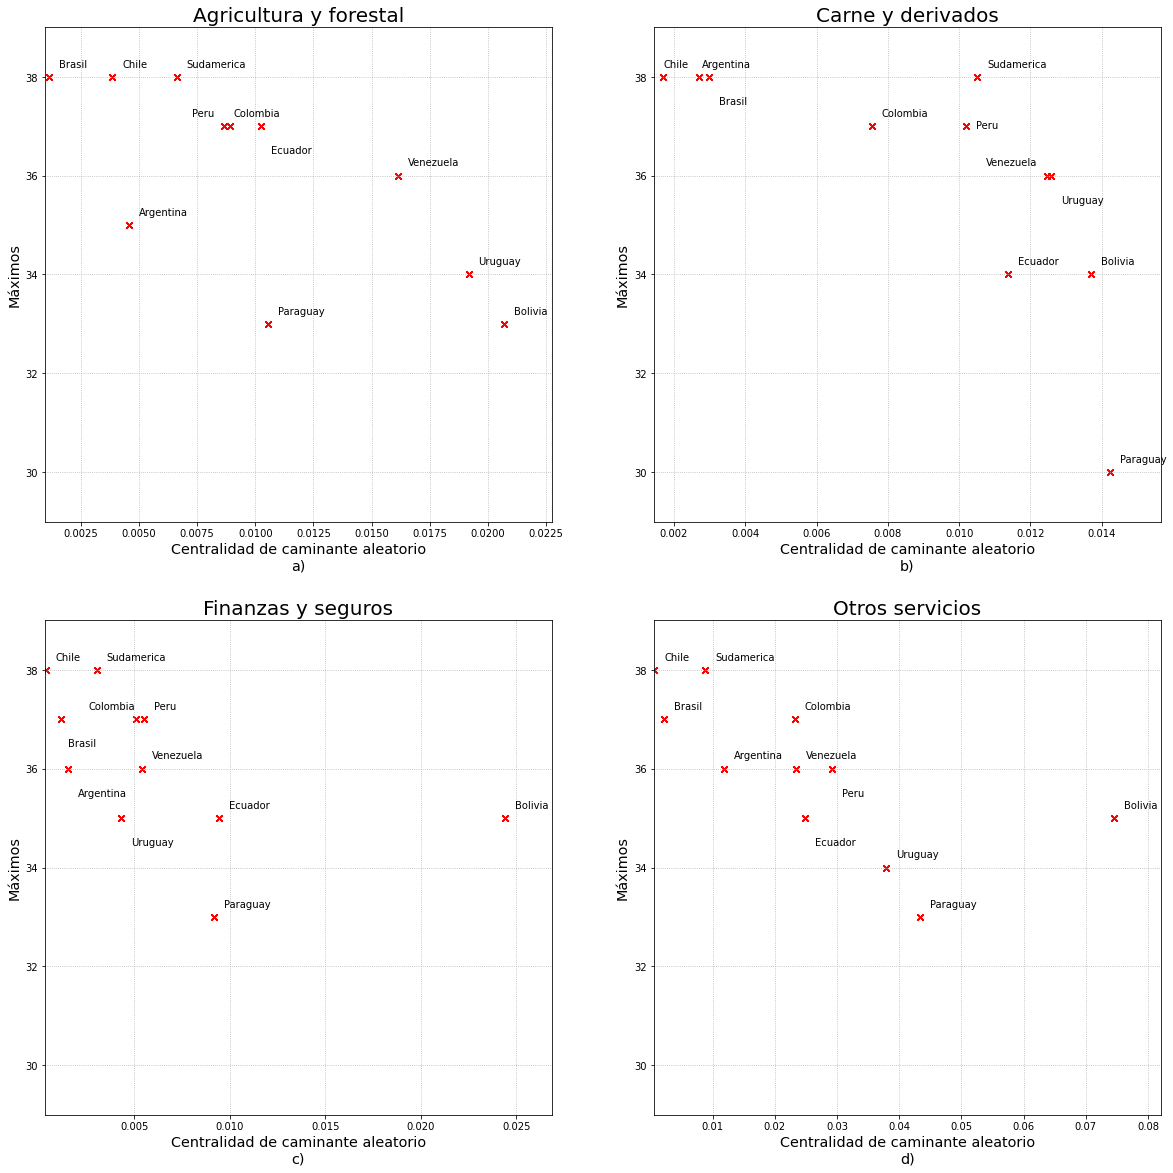

In [32]:
titulos = ['Agricultura y forestal', 'Carne y derivados',
           'Finanzas y seguros', 'Otros servicios']

letras = ['a)', 'b)', 'c)', 'd)']

fig, axs = plt.subplots(2,2, figsize=(20,20))

for ax, x, y, titulo, letra in zip(axs.flat, X, Y, titulos, letras): 

    ax.set_title(titulo, fontdict={'fontsize': 20})
    ax.set_xlabel('Centralidad de caminante aleatorio\n{}'.format(letra), fontsize='x-large')
    ax.set_ylabel('Máximos', fontsize='x-large')
    ax.grid(linestyle=':')
    ax.set_xlim(min(x)*(1-.15), max(x)*(1+.10))
    ax.set_ylim(29, 39)
        
   
    if titulo == 'Agricultura y forestal':
        
        x_1 =x.copy()
        x_1[7] = x_1[7]-0.0018
        x_1[4] = x_1[4]-0.0003
    
        y_1 = y.copy()
        y_1[5] = y_1[5]-.75
        
        for i, txt in enumerate(list(maximos_finanzas.keys())):
            ax.annotate(txt, (x_1[i], y_1[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')
            
    elif titulo == 'Carne y derivados':
        x_1 =x.copy()
        x_1[0] = x_1[0]-0.0002
        x_1[3] = x_1[3]-0.00025
        x_1[10] = x_1[10]-0.0020
    
        y_1 = y.copy()
        y_1[2] = y_1[2]-.75
        y_1[7] = y_1[7]-.25
        y_1[9] = y_1[9]-.75
        
        
        
        for i, txt in enumerate(list(maximos_finanzas.keys())):
            ax.annotate(txt, (x_1[i], y_1[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')
            
            
    elif titulo == 'Finanzas y seguros':
    
        x_1 =x.copy()
        x_1[2] = x_1[2]-0.0002
        x_1[4] = x_1[4]-0.0030

    
        y_1 = y.copy()
        y_1[0] = y_1[0]-.75
        y_1[2] = y_1[2]-.75
        y_1[9] = y_1[9]-.75
        
        
        for i, txt in enumerate(list(maximos_finanzas.keys())):
            ax.annotate(txt, (x_1[i], y_1[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')
            
            
    else:
        y_1 = y.copy()
        y_1[5] = y_1[5]-.75
        y_1[7] = y_1[7]-.75
            
        for i, txt in enumerate(list(maximos_finanzas.keys())):
            ax.annotate(txt, (x[i], y_1[i]), xytext=(10,10), textcoords='offset points')
            ax.scatter(x, y, marker='x', color='red')

----

# Información del notebook

In [34]:
import session_info
session_info.show(cpu=True, html=False)

-----
matplotlib          3.5.1
numpy               1.21.2
pandas              1.3.3
scipy               1.4.1
session_info        1.0.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.8.10 (default, Mar 13 2023, 10:26:41) [GCC 9.4.0]
Linux-5.15.0-69-generic-x86_64-with-glibc2.29
4 logical CPU cores, x86_64
-----
Session information updated at 2023-03-29 11:30
